# Building a neural network

We start with a simple binary classification problem to demonstrate how neural networks work. Here's our (generated) dataset of two blue and red classes encoded with `0` and `1`.

In [1]:
import random
import matplotlib.pyplot as plt


xs = [(random.normalvariate(0, 1) - 5 , random.normalvariate(0, 1)) for _ in range(100)] \
    + [(random.normalvariate(0, 1) + 5 , random.normalvariate(0, 1)) for _ in range(100)]
ys = [1 for _ in range(100)] + [0 for _ in range(100)]

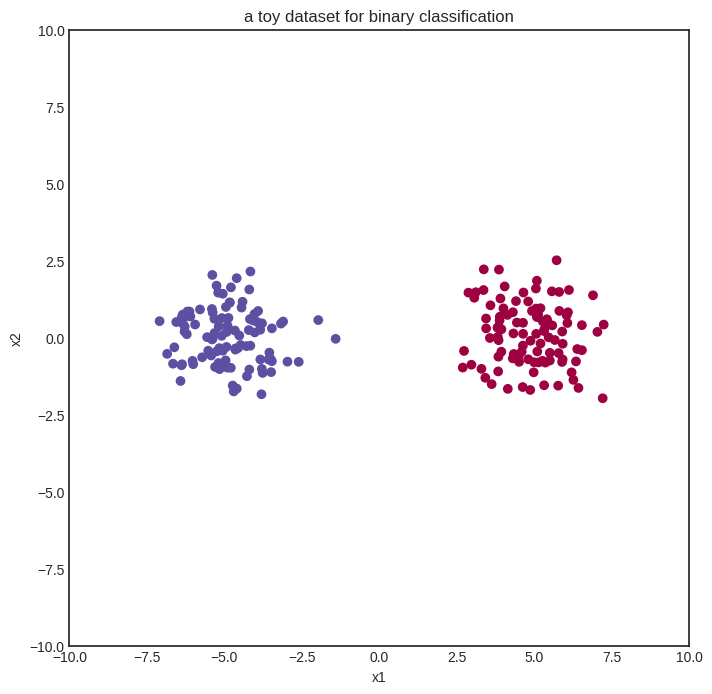

In [2]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.title("a toy dataset for binary classification")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

We'll start with the simplest neural network: zero hidden layers and sigmoid activation. This is also known as logistic regression. Here we go:

In [3]:
from mlfz.nn import Model
from mlfz.nn.scalar import Scalar, sigmoid, binary_cross_entropy


class ZeroLayerNetwork(Model):
    def __init__(self):
        self.a1 = Scalar(1)
        self.a2 = Scalar(1)
        self.b = Scalar(1)

    def forward(self, x):
        x1, x2 = x
        return sigmoid(self.a1 * x1 + self.a2 * x2 + self.b)
    
    def parameters(self):
        return {"a1": self.a1, "a2": self.a2, "b": self.b}

In [4]:
model = ZeroLayerNetwork()

We can visualize the untrained model on a heatmap, coloring according to predictions.

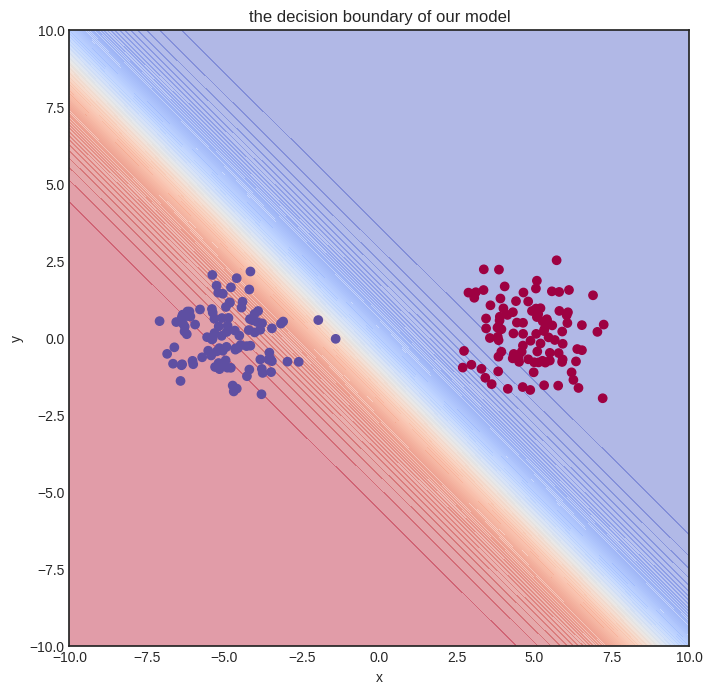

In [5]:
import numpy as np


def visualize_model(model, xs, ys, res=100, xrange=(-10, 10), yrange=(-10, 10)):
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(8, 8))
        
        res = 100
        x = np.linspace(xrange[0], xrange[1], res)
        y = np.linspace(yrange[0], yrange[1], res)
        xx, yy = np.meshgrid(x, y)
        
        zz = np.vectorize(lambda x, y: model((x, y)).value)(xx, yy)

        # plot the decision boundary
        plt.contourf(xx, yy, zz, levels=100, cmap='coolwarm_r', alpha=0.4)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('the decision boundary of our model')
        
        # plot the data
        plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral, zorder=10)
        plt.show()


visualize_model(model, xs, ys)

The initial model gets nothing right, so let's train it!

In [6]:
n_steps = 100
lr = 0.1

for i in range(1, n_steps + 1):
    preds = [model(x) for x in xs]
    l = binary_cross_entropy(preds, ys)
    l.backward()
    model.gradient_update(lr)

    if i == 1 or i % 10 == 0:
        print(f"step no. {i}, loss = {l.value}")

step no. 1, loss = 4.928418545931436
step no. 10, loss = 0.09667107819866706
step no. 20, loss = 0.040314825520221476
step no. 30, loss = 0.025630653822378804
step no. 40, loss = 0.018867359351573396
step no. 50, loss = 0.014972822886378506
step no. 60, loss = 0.012438731038922983
step no. 70, loss = 0.01065677910427249
step no. 80, loss = 0.009334457275173675
step no. 90, loss = 0.008313633580770155
step no. 100, loss = 0.007501319653091092


Here's how the model performs after training.

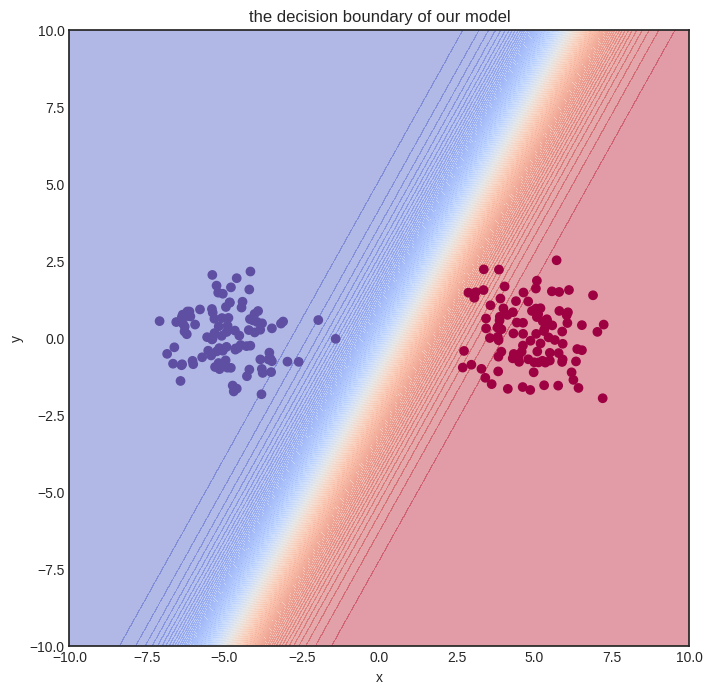

In [7]:
visualize_model(model, xs, ys)

Solving a simple problem like that is no big deal. Can we handle more complex datasets?

(computational-graphs:mlp:a-multi-layer-network)=
## A multi-layer network

Here's a spiral-like dataset with classes intertwined into each other.

In [8]:
import math


def generate_spiral_dataset(n_points, noise=0.5, twist=380):
    random_points = [math.sqrt(random.random()) * twist * 2 * math.pi/360 for _ in range(n_points)]

    class_1 = [(-math.cos(p) * p + random.random()*noise, math.sin(p) * p + random.random()*noise) for p in random_points]
    class_2 = [(math.cos(p) * p + random.random()*noise, -math.sin(p) * p + random.random()*noise) for p in random_points]

    xs = class_1 + class_2
    ys = [0 for _ in class_1] + [1 for _ in class_2]
    
    return xs, ys

In [9]:
xs, ys = generate_spiral_dataset(200, noise=2)

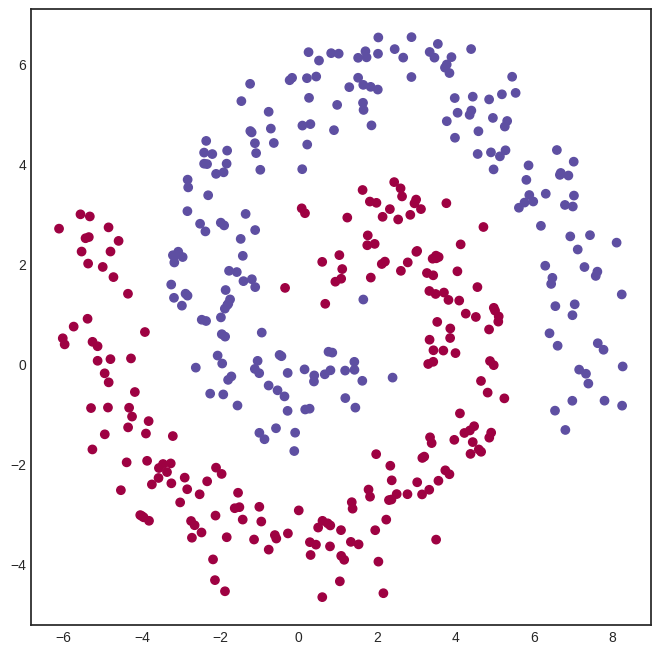

In [10]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    plt.scatter([x[0] for x in xs], [x[1] for x in xs], c=ys, cmap=plt.cm.Spectral)
    plt.show()

For this problem, we need a hidden layer. Here's a model with a hidden layer of eight neurons, connected via the

$$
\mathrm{tanh}(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

activation function.

In [11]:
from mlfz.nn.scalar import tanh
from itertools import product


class OneLayerNetwork(Model):
    def __init__(self):
        self.A = [[Scalar.from_random() for j in range(8)]
                  for i in range (2)]
        self.B = [Scalar.from_random() for i in range(8)]
    
    def forward(self, x):
        """
        x: a tuple of two Scalars
        """
        fs = [sum([self.A[i][j] * x[i] for i in range(2)]) for j in range(8)]
        fs_relu = [tanh(f) for f in fs]
        gs = sum([self.B[i] * fs_relu[i] for i in range(8)])
        return sigmoid(gs)

    def parameters(self):
        A_dict = {f"a{i}{j}": self.A[i][j] for i, j in product(range(2), range(8))}
        B_dict = {f"b{i}": self.B[i] for i in range(8)}
        return {**A_dict, **B_dict}

We can already see one of the glaring flaws of our `Scalar` implementation of computational graphs: the inability to write vectorized code. For instance, the expression

```
fs = [sum([self.A[i][j] * x[i] for i in range(2)]) for j in range(8)]
```

is simply the matrix product of the input `x` and the $ 2 \times 8 $ parameter matrix `A`.

We'll deal with vectorization later with the `Tensor` class, but let's stick to the vanilla version for now. Here's our model.

In [12]:
model = OneLayerNetwork()

And here's how the untrained model looks.

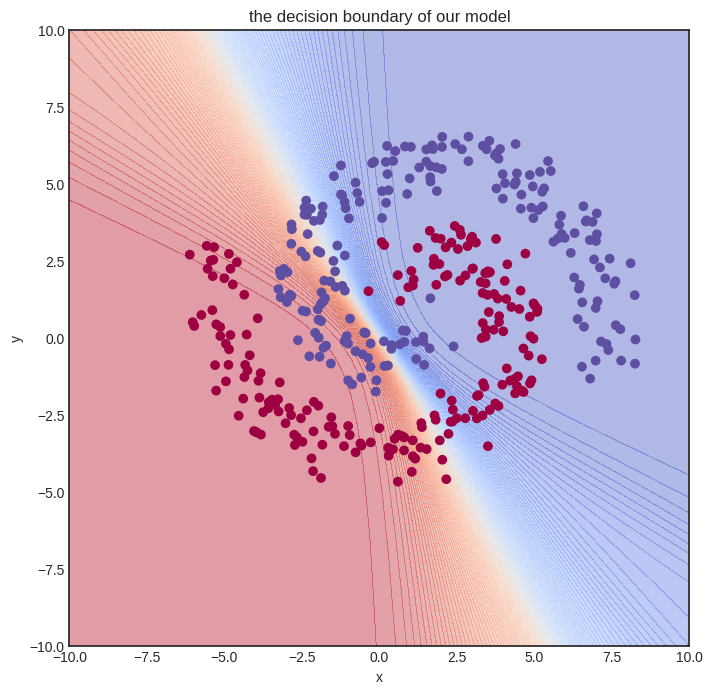

In [13]:
visualize_model(model, xs, ys)

Let's train it! We'll need quite some more steps. To spice things up, we'll also use a simple learning rate tuning: `lr=1` for the first hundred gradient descent steps, `lr=0.5` for the second hundred, and `lr=0.1` after.

In [14]:
n_steps = 5000
lr = 0.1

for i in range(1, n_steps + 1):
    preds = [model(x) for x in xs]
    l = binary_cross_entropy(preds, ys)
    l.backward()
    model.gradient_update(lr)

    if i == 1 or i % 100 == 0:
        print(f"step no. {i}, loss = {l.value}")

step no. 1, loss = 1.647234194234771


Just for the fun of it, let's time the training.

In [15]:
def train_model():
    model = OneLayerNetwork()
    n_steps = 5000
    lr = 0.1

    for i in range(1, n_steps + 1):
        preds = [model(x) for x in xs]
        l = binary_cross_entropy(preds, ys)
        l.backward()
        model.gradient_update(lr)


%timeit -r 1 -n 1 train_model()

2.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


This training took sixteen minutes to execute on my Lenovo Thinkpad and probably much more on the Read The Docs servers. (My apologies.) Again, this is the consequence of non-vectorized code. Were these sixteen minutes enough? Let's see.

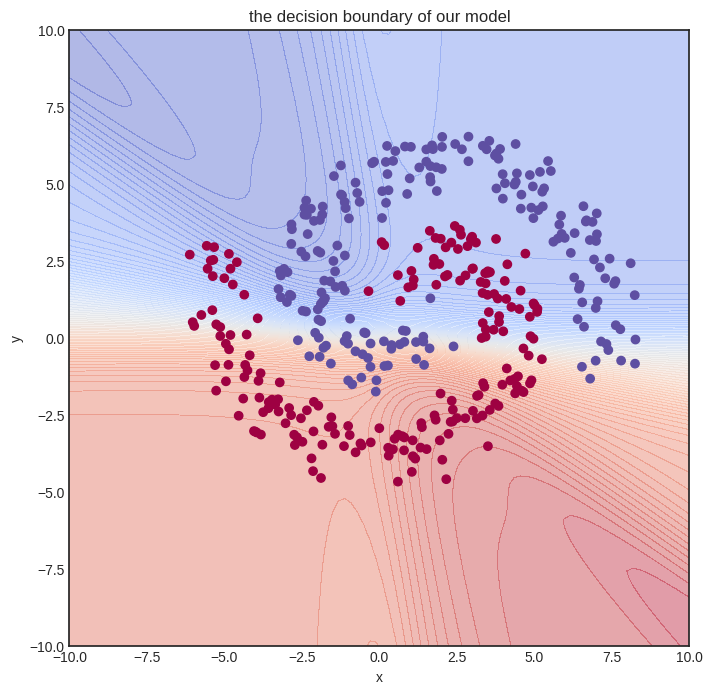

In [17]:
visualize_model(model, xs, ys)

Not perfect, but good enough. We can already see that the decision boundary is starting to conform to the data.

## Coming soon
In the later chapters of this documentation, we'll detail how `Scalar` is implemented to understand how computational graphs work.